### Задание 1 - по тетрадке sem01_autograd.

1. Добавить Bias и посчитать для них градиенты.
2. Сравнить градиенты с тем, как считает PyTorch AutoGrad.

In [1]:
import numpy as np
import torch

In [ ]:
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# Randomly initialize weights
w11 = torch.randn(input_size, hidden_size, device=device, dtype=dtype)
w12 = torch.randn(hidden_size, output_size, device=device, dtype=dtype)
b11 = torch.randn(1, hidden_size, device=device, dtype=dtype)
b12 = torch.randn(1, output_size, device=device, dtype=dtype)

learning_rate = 1e-6

In [ ]:

for t in range(500):
    h_1 = x.mm(w11) + b11
    h_relu = h_1.clamp(min=0)
    out = h_relu.mm(w12) + b12

    loss = (out - y).pow(2).sum().item()

    dloss_out = 2 * (out - y)
    grad_w2 = h_relu.t().mm(dloss_out)
    grad_b2 = dloss_out.sum(dim=0)

    grad_hrelu = dloss_out.mm(w12.t())
    grad_hrelu[h_1 < 0] = 0
    grad_w1 = x.t().mm(grad_hrelu)
    grad_b1 = grad_hrelu.sum(dim=0)


    w11 -= learning_rate * grad_w1
    w12 -= learning_rate * grad_w2
    b11 -= learning_rate * grad_b1
    b12 -= learning_rate * grad_b2


    if t % 100 == 99:
        print(f'Loss on iteration {t} = {loss}')



Loss on iteration 99 = 146.34942626953125
Loss on iteration 199 = 142.14781188964844
Loss on iteration 299 = 138.3956756591797
Loss on iteration 399 = 135.03366088867188
Loss on iteration 499 = 132.01121520996094


In [ ]:
w1 = w11.clone().detach().requires_grad_(True)
w2 = w12.clone().detach().requires_grad_(True)
b1 = b11.clone().detach().requires_grad_(True)
b2 = b12.clone().detach().requires_grad_(True)

for t in range(500):
    y_pred = (x.mm(w1) + b1).clamp(min=0).mm(w2) + b2

    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f"Iteration {t}: Loss = {loss.item()}")


    loss.backward()

    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        b1 -= learning_rate * b1.grad
        b2 -= learning_rate * b2.grad

        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

Iteration 99: Loss = 146.34942626953125
Iteration 199: Loss = 142.14781188964844
Iteration 299: Loss = 138.3956756591797
Iteration 399: Loss = 135.03366088867188
Iteration 499: Loss = 132.01121520996094


Они одинаковые!


### Задание 2.

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка, и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('/content/data.csv',index_col=0)

Как и в любой задаче машинного обучения, для начала надо визуализировать данные.
Не зря же нашу нейронную сеть мы так долго учим?


<Axes: xlabel='x1', ylabel='x2'>

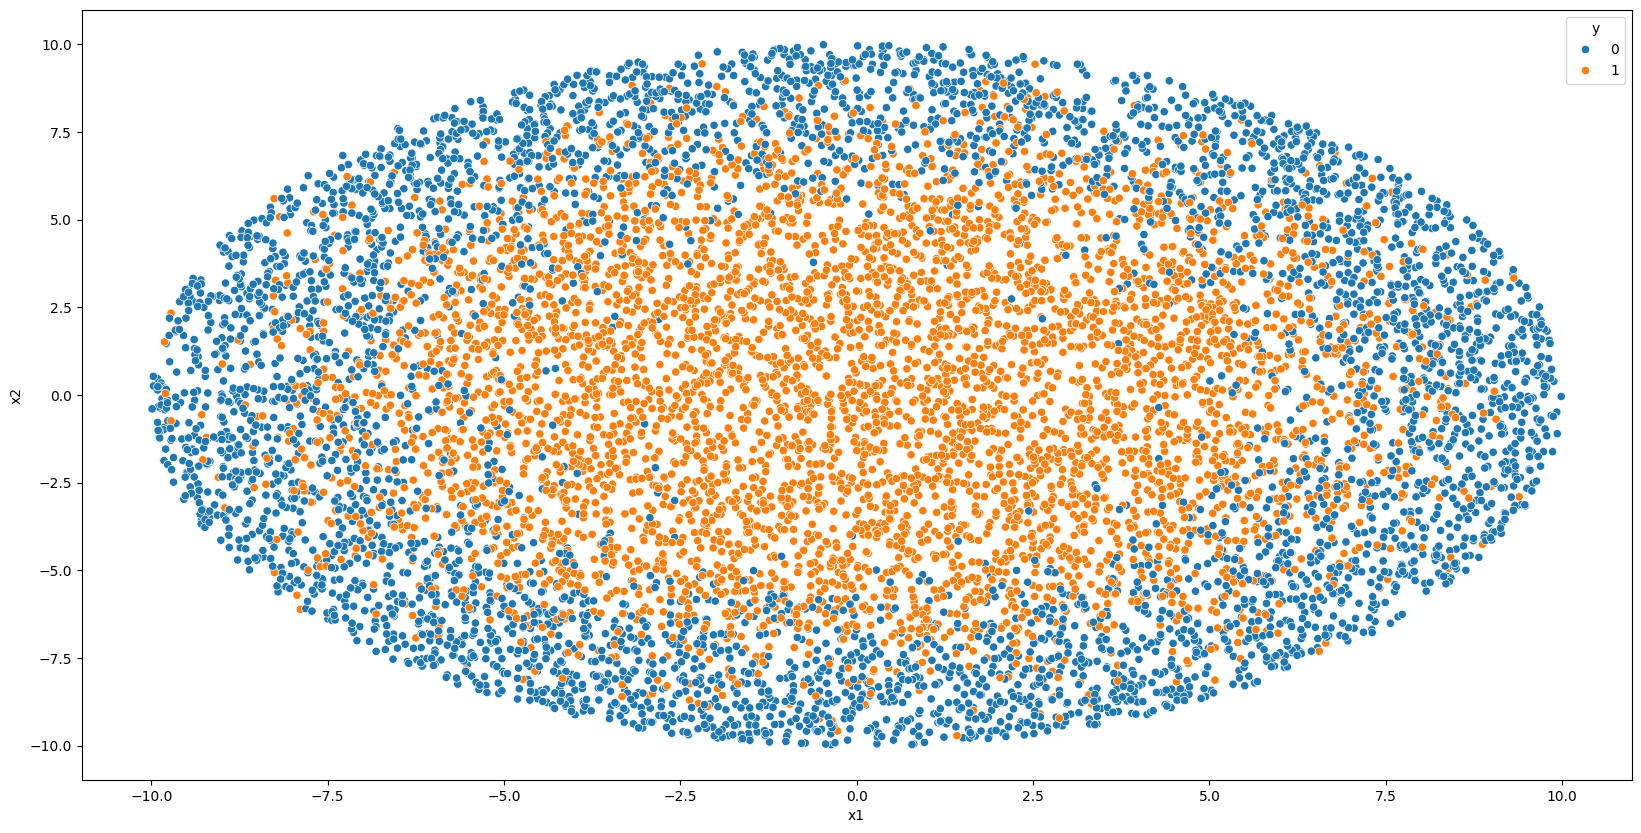

In [4]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data=df)

После просмотра данных встает несколько вопросов:
 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)
 * 2) Что ещё мы хотим знать о выборке?
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# разобьем выборку на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=['x1', 'x2'])
X_test = pd.DataFrame(scaler.transform(X_test), columns=['x1', 'x2'])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(6700, 2)
(6700,)


Точность нашей модели 0.5827272727272728


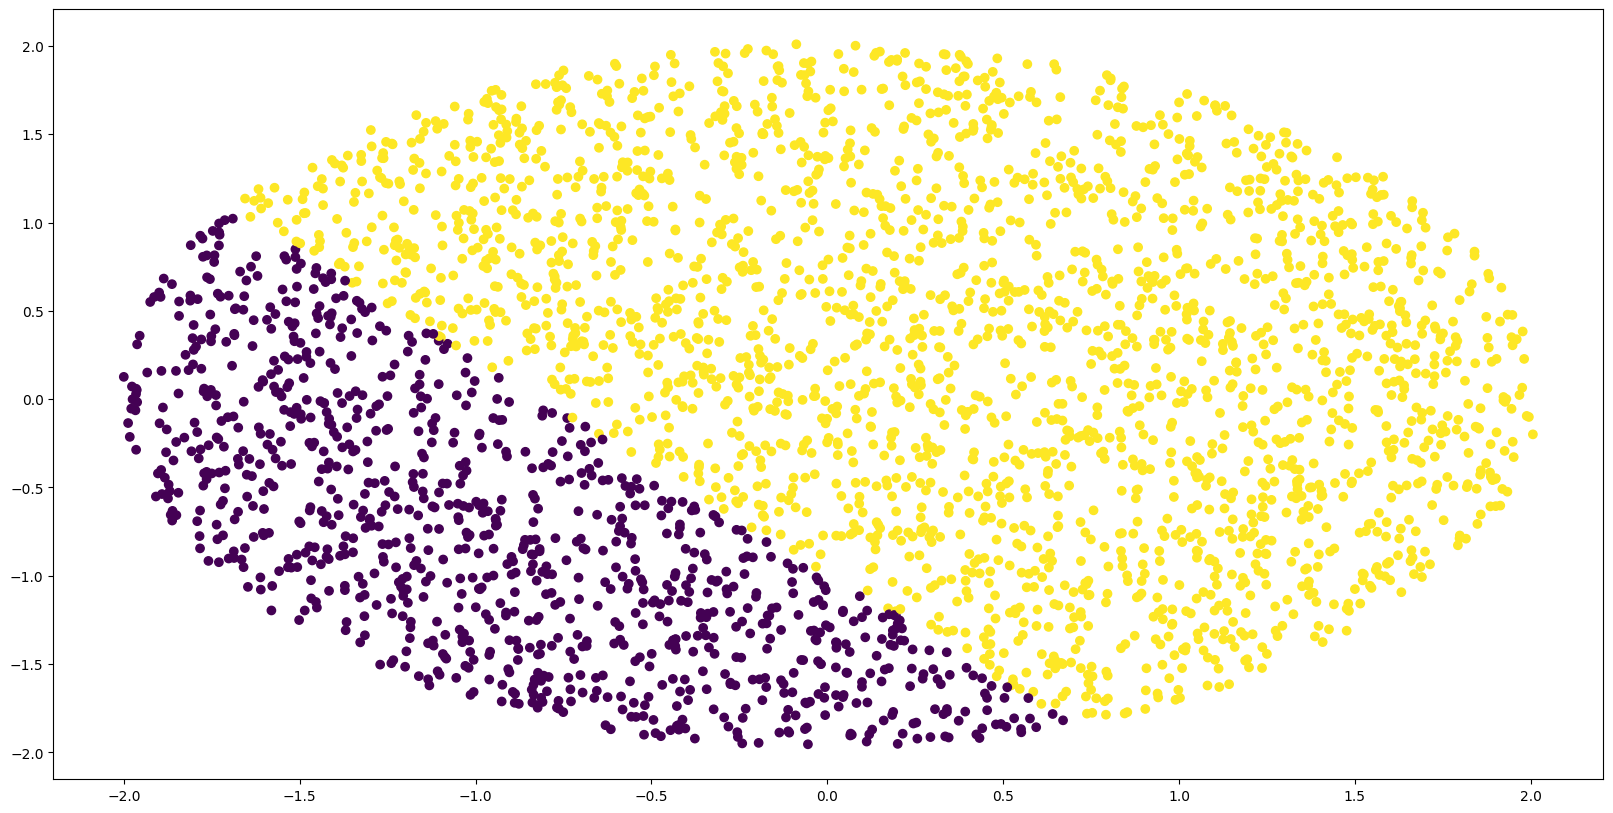

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
predict_logit = model.predict(X_train)
predict_log_proba = model.predict(X_test)



print(f'Точность нашей модели {accuracy_score(predict_log_proba, y_test)}')

# Заодно завизуализируем полученные результаты
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba)
plt.show()

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

Точность нашей модели 0.8409090909090909


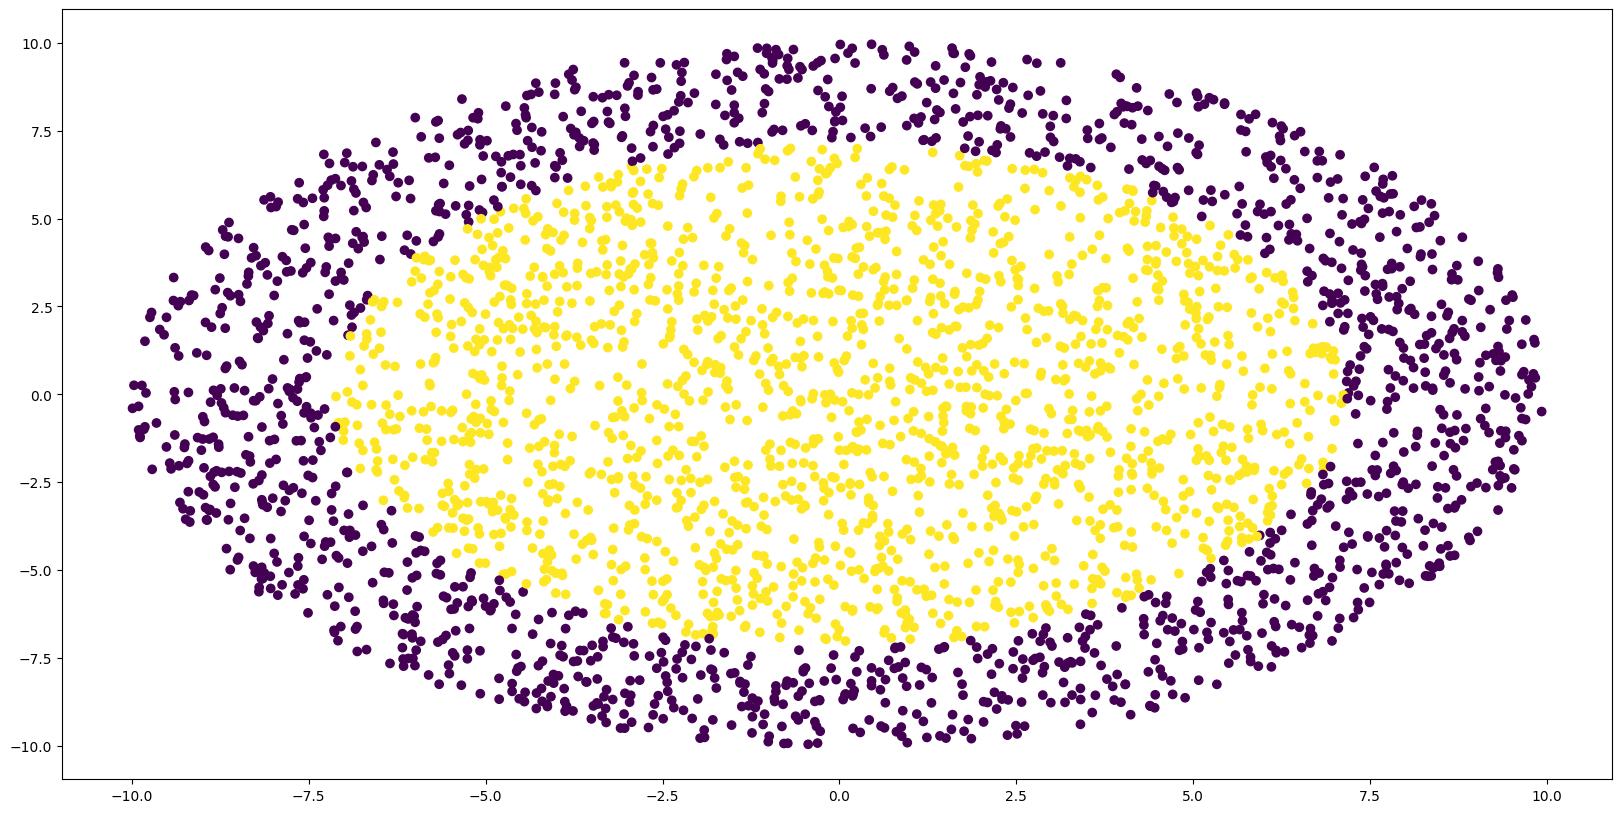

In [ ]:
# Повторяем наш код, только с новыми фичами - смотрим на магию
df_new = df.copy()

#########################################
# ваш код для фичей и новой модели

df_new['new_feature_1'] = df_new['x1'].pow(2) + df_new['x2'].pow(2) #получим квадрат радиуса окружности, на которой лежит точка, т.е. насколько далеко она удалена от центра

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'new_feature_1']],
                                                                    df_new['y'], test_size=0.33)



model.fit(X_train_new, y_train_new)
predict_logit = model.predict(X_train_new)
predict_log_proba = model.predict(X_test_new)

#########################################

print(f'Точность нашей модели {accuracy_score(predict_log_proba,y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

И точность на 0.2 выросла и картинка посимпатичнее.


Переходим к следующему классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафикисировать, чтобы эта особенность не испортила обучение?

Точность нашей модели 0.759090909090909


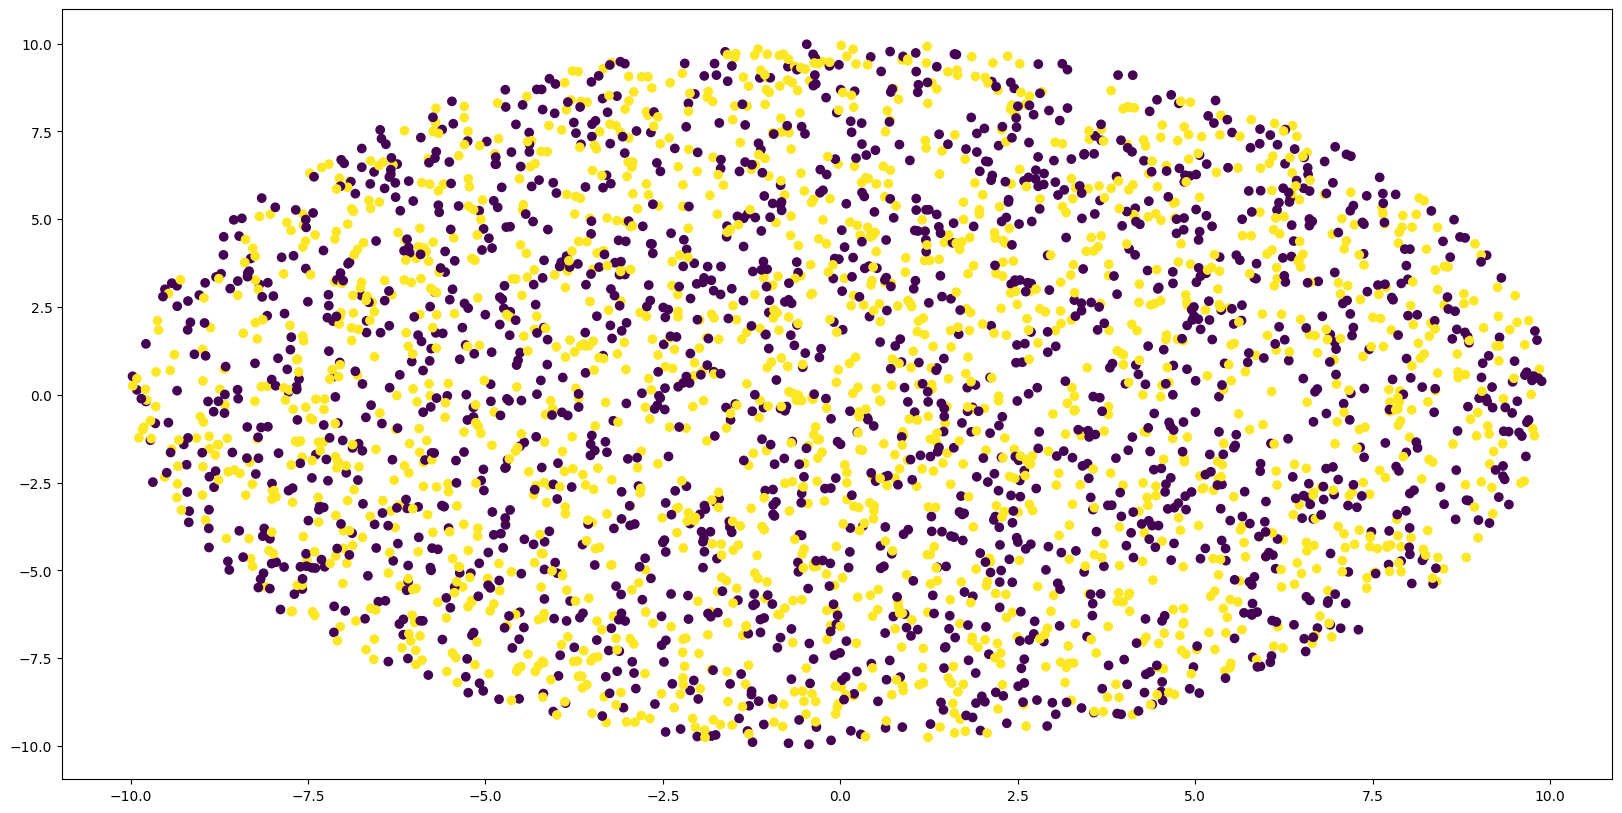

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train_new, y_train_new)

predict_tree = dt.predict(X_test_new)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test_new)}')

#predict_tree_proba = # ...

#########################################

plt.figure(figsize=(20,10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_tree)
plt.show()

In [ ]:
Выглядит грустно, но здесь не подобраны параметры модели (глубина деревьев и число объектов в вершинах).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
param_dist = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
rs = RandomizedSearchCV(dt,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(X_train_new, y_train_new)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'min_samples_leaf': 39, 'max_depth': 1}

In [ ]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'params',
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
            'std_test_score'],
            axis=1)


param_min_samples_leaf  param_max_depth  mean_test_score  rank_test_score
0                      39                2         0.837912                1
1                       2                2         0.837912                1
2                      39                3         0.837912                1
3                      34                3         0.837912                1
4                      12                3         0.837912                1
5                      44                1         0.837912                1
6                      23                3         0.837912                1
7                      18                2         0.837912                1
8                      34                2         0.837912                1
9                      44                2         0.837912                1

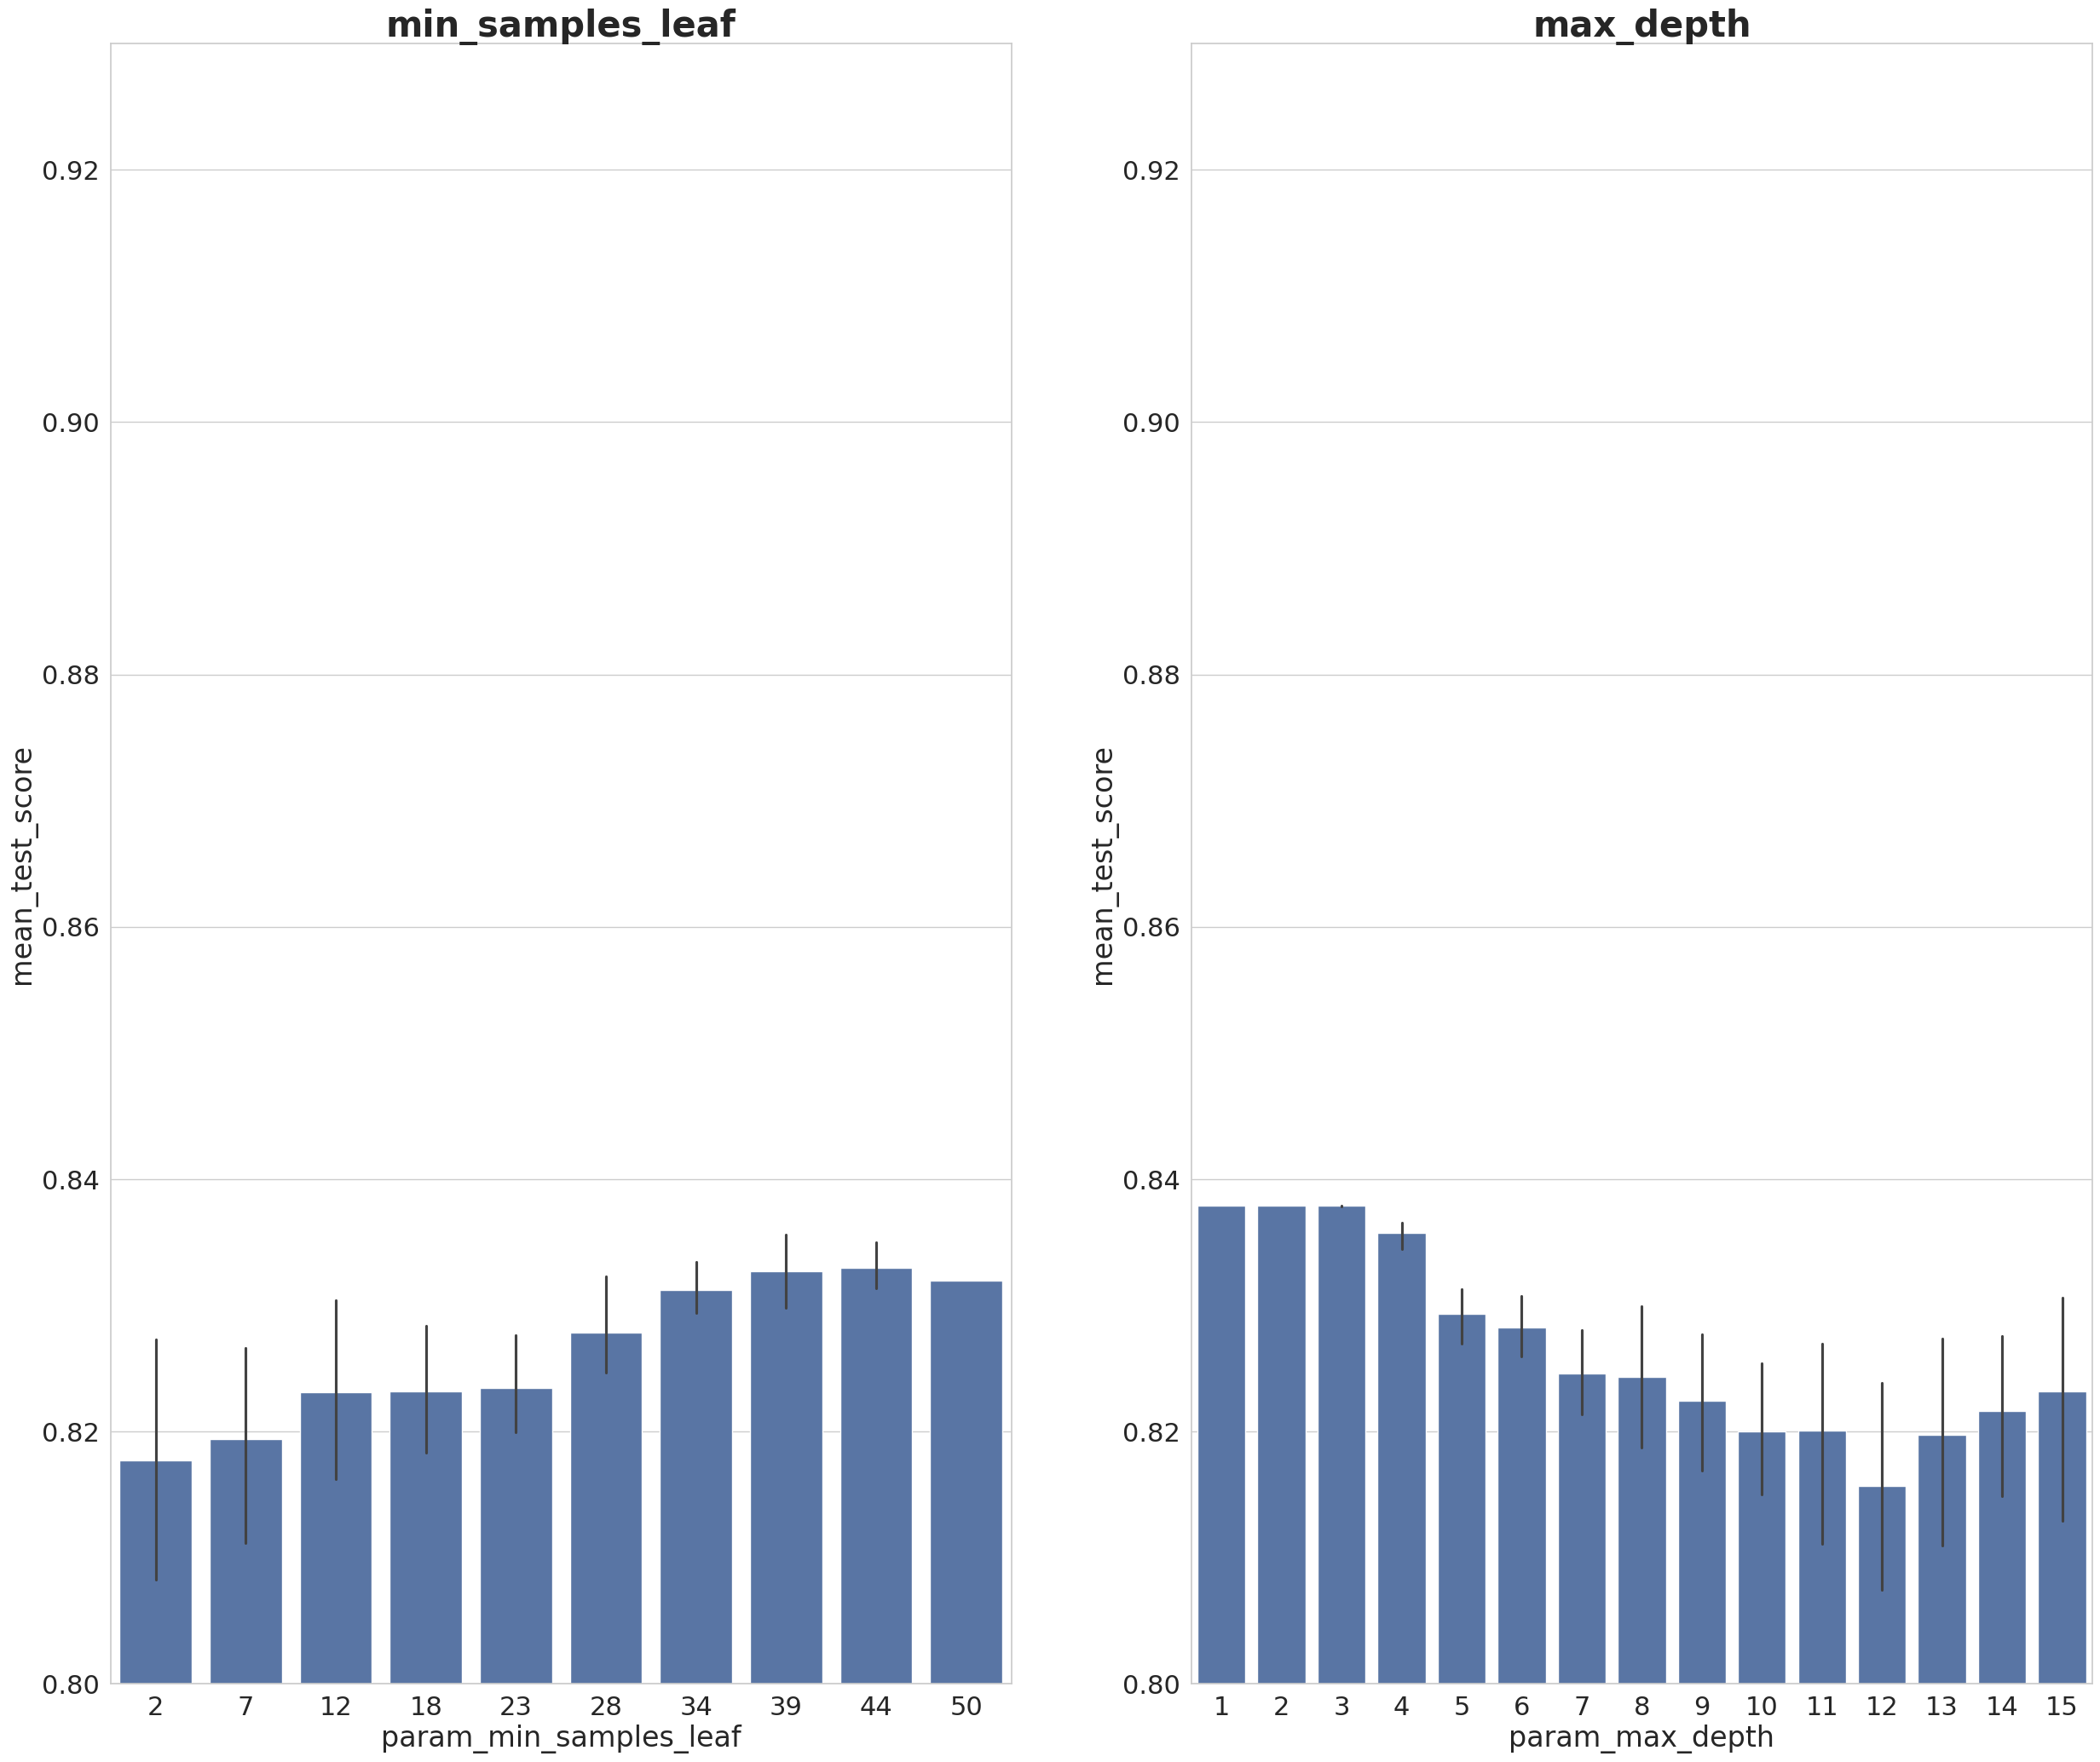

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1)
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig.set_size_inches(30, 25)

# График для параметра min_samples_leaf
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0])
axs[0].set_ylim([0.80, 0.93])
axs[0].set_title(label='min_samples_leaf', size=30, weight='bold')

# График для параметра max_depth
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1])
axs[1].set_ylim([0.80, 0.93])
axs[1].set_title(label='max_depth', size=30, weight='bold')

plt.show()

Я помню только про GridSearch, остальное взяла из чужого кода, но, вроде бы, получилось:)

In [ ]:
from sklearn.model_selection import GridSearchCV
max_depth = [2, 3, 4, 5]
min_samples_leaf = [30, 35, 40, 45]
param_grid = { 'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
gs = GridSearchCV(dt, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_new, y_train_new)
dt_new = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_depth': 2, 'min_samples_leaf': 30}

Точность нашей модели 0.8372727272727273


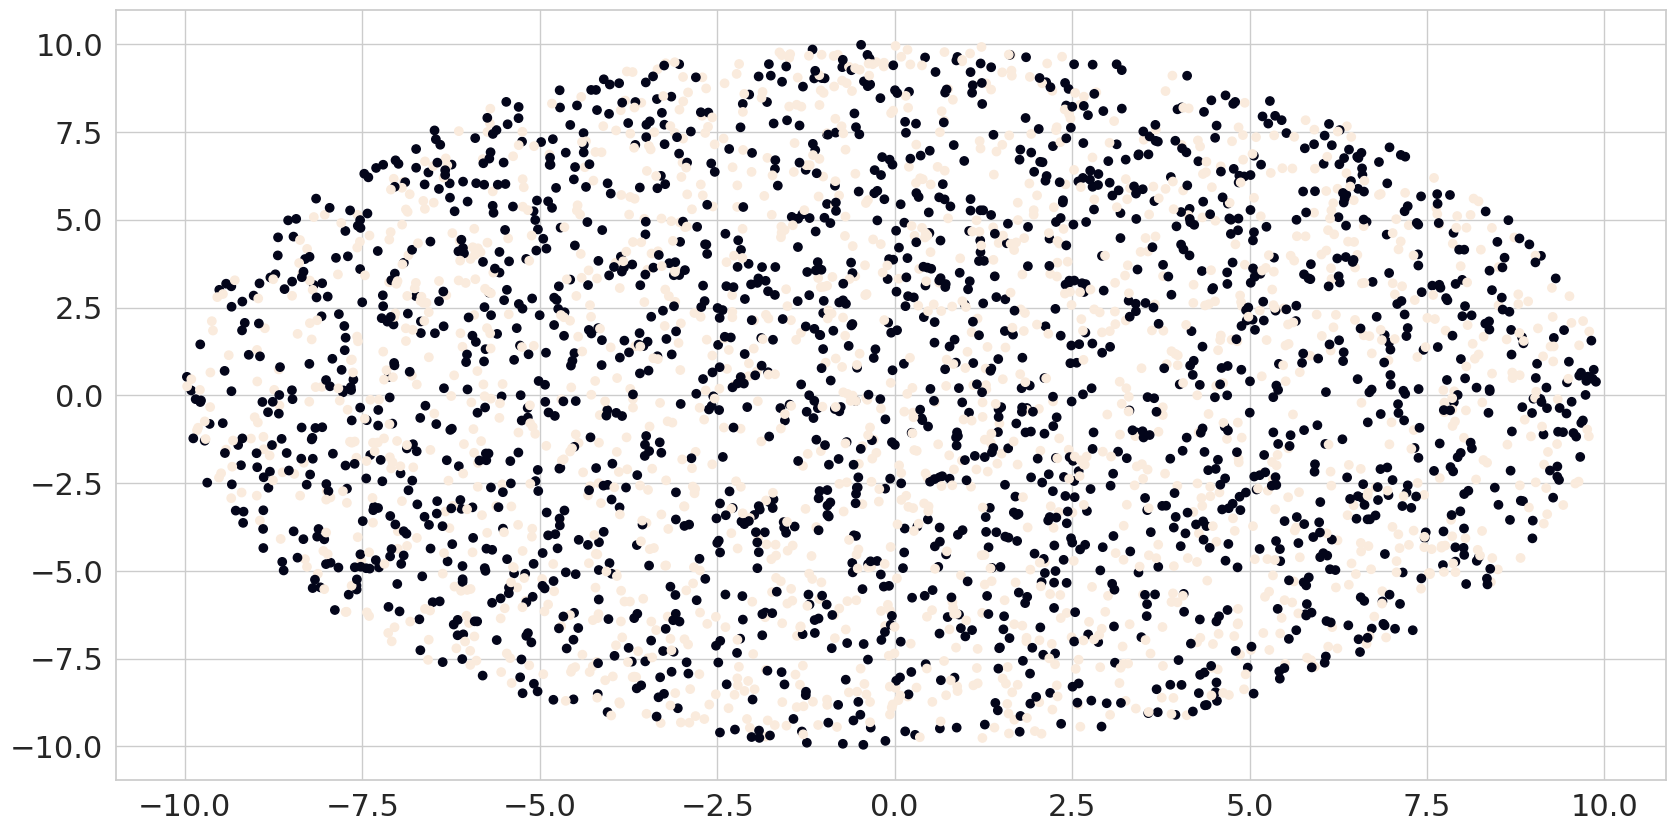

In [ ]:
dt_new.fit(X_train_new, y_train_new)

predict_tree = dt_new.predict(X_test_new)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test_new)}')



plt.figure(figsize=(20,10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_tree)
plt.show()

Точность подросла, но картинка все еще так себе...


Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

Точность нашей модели 0.49575757575757573


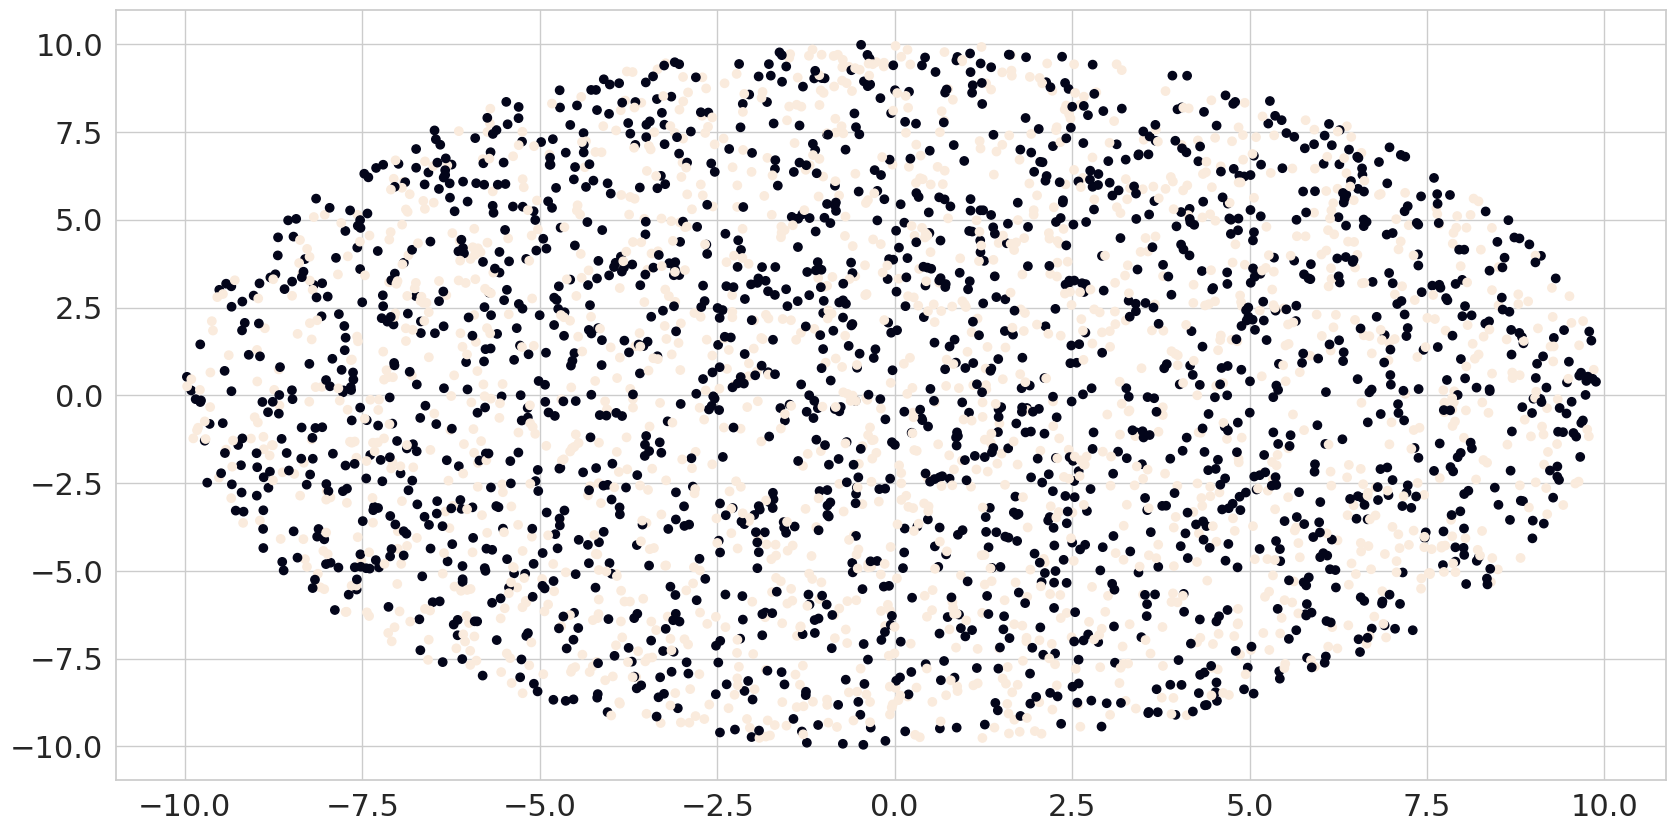

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_new, y_train_new)

predict_forest = rf.predict(X_test_new)
predict_forest_proba = rf.predict(X_train_new)

print(f'Точность нашей модели {accuracy_score(predict_forest, y_test)}')



#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_forest)
plt.show()

Это, конечно, печально...

In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
} #добавила больше параметров для подбора

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train_new, y_train_new)
rf_new = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 6, 'n_estimators': 50}

Точность нашей модели 0.49363636363636365


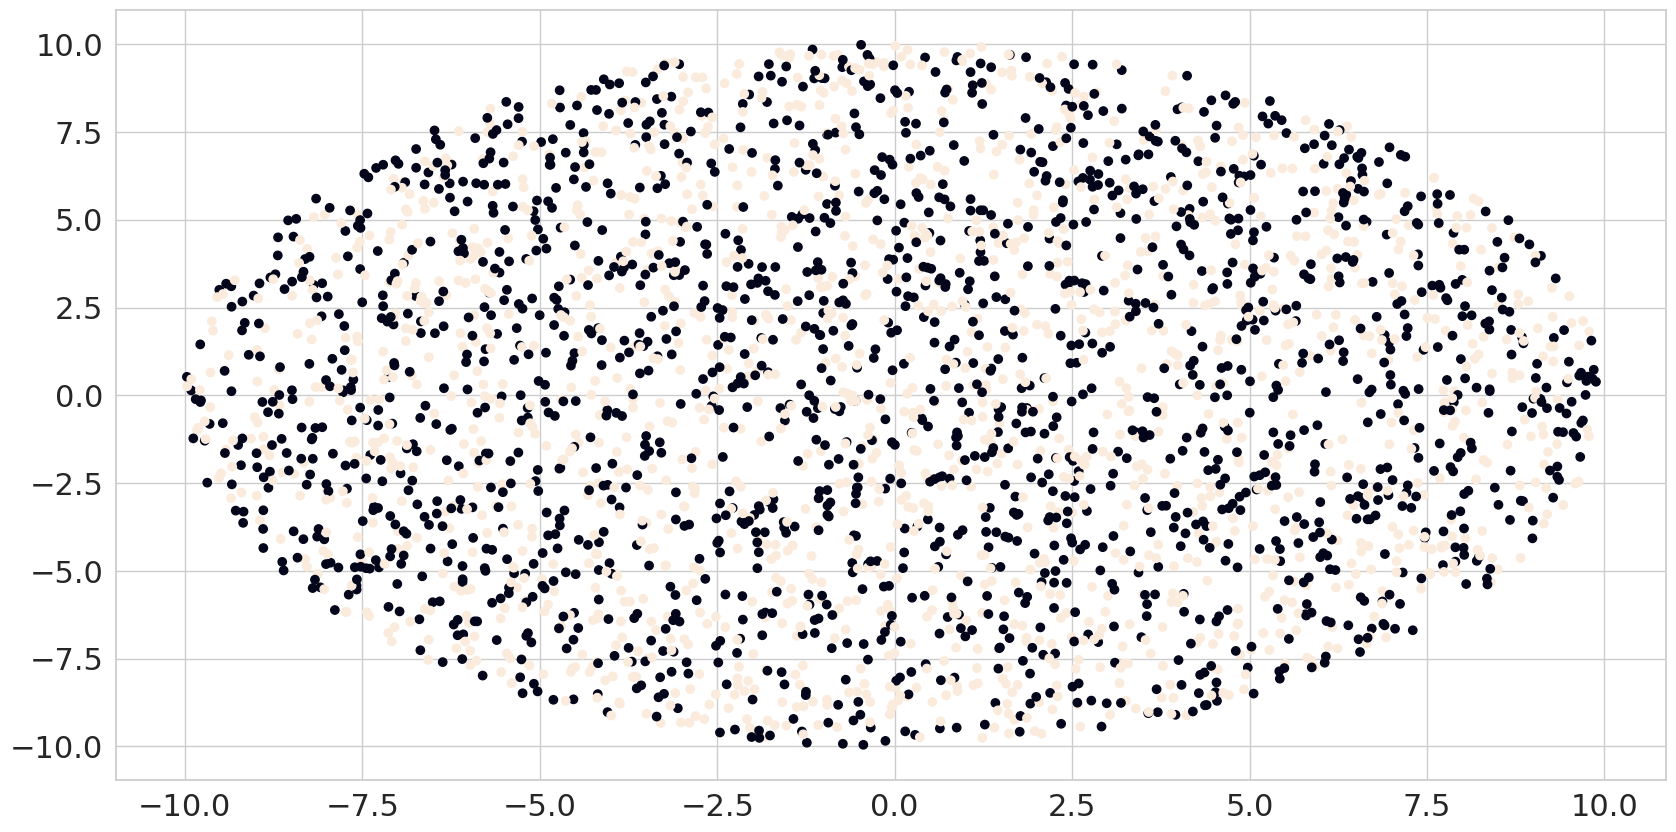

In [ ]:
rf_new.fit(X_train_new, y_train_new)

predict_forest = rf_new.predict(X_test_new)
predict_forest_proba = rf_new.predict(X_train_new)

print(f'Точность нашей модели {accuracy_score(predict_forest, y_test)}')



#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_forest)
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом.

In [8]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchmetrics import Accuracy
from tqdm.notebook import tqdm


In [7]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 18.2 MB/s eta 0:00:00


In [9]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=64,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=64,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())

In [30]:
model = nn.Sequential(
          nn.Linear(2, 5),
          nn.Sigmoid(),
          nn.Linear(5, 1),
          nn.Sigmoid())

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [31]:
for epoch in range(10):
     for batch_X, batch_y in tqdm(train_loader):
        y_pred = model(batch_X)
        loss = F.binary_cross_entropy(y_pred, batch_y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

     if epoch % 2 == 0:
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader):
                y_pred = model(batch_X)
                loss = F.binary_cross_entropy(y_pred, batch_y.float().unsqueeze(1)) #это у меня сначала ничего не работало, и я нашла, что для бинарной классификации нужна отдельная энтропия
                val_loss.append(loss.cpu().numpy())


                predicted = (y_pred > 0.5).int() #accuracy выросла примерно на 0.4 после того, как поменяла 0 на 0.5, как я поняла, это для бинарной классификации
                val_accuracy.extend((predicted.squeeze() == batch_y).cpu().numpy().tolist())

        # Печать метрик
        print(f"Epoch: {epoch}, validation loss: {np.mean(val_loss)}, validation accuracy: {np.mean(val_accuracy)}")


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 0, validation loss: 0.5184449553489685, validation accuracy: 0.803939393939394


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2, validation loss: 0.40918299555778503, validation accuracy: 0.8151515151515152


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4, validation loss: 0.38686153292655945, validation accuracy: 0.826969696969697


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6, validation loss: 0.38174301385879517, validation accuracy: 0.8324242424242424


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 8, validation loss: 0.37732937932014465, validation accuracy: 0.8375757575757575


  0%|          | 0/105 [00:00<?, ?it/s]

Результат на изначальном датасете с двумя признаками (без радиуса), на котором у лог. регресии accuracy была 0.5.
Пробовала learning rate 0.01, результат был похуже.
Качество сильно улучшилось после замены SGD на Adam (0.59 -> 0.83).
Еще пробовала во втором слое заменить сигмоиду на релу, результат был чуть-чуть пониже (0.82).

In [19]:
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.values, dtype=torch.float32))




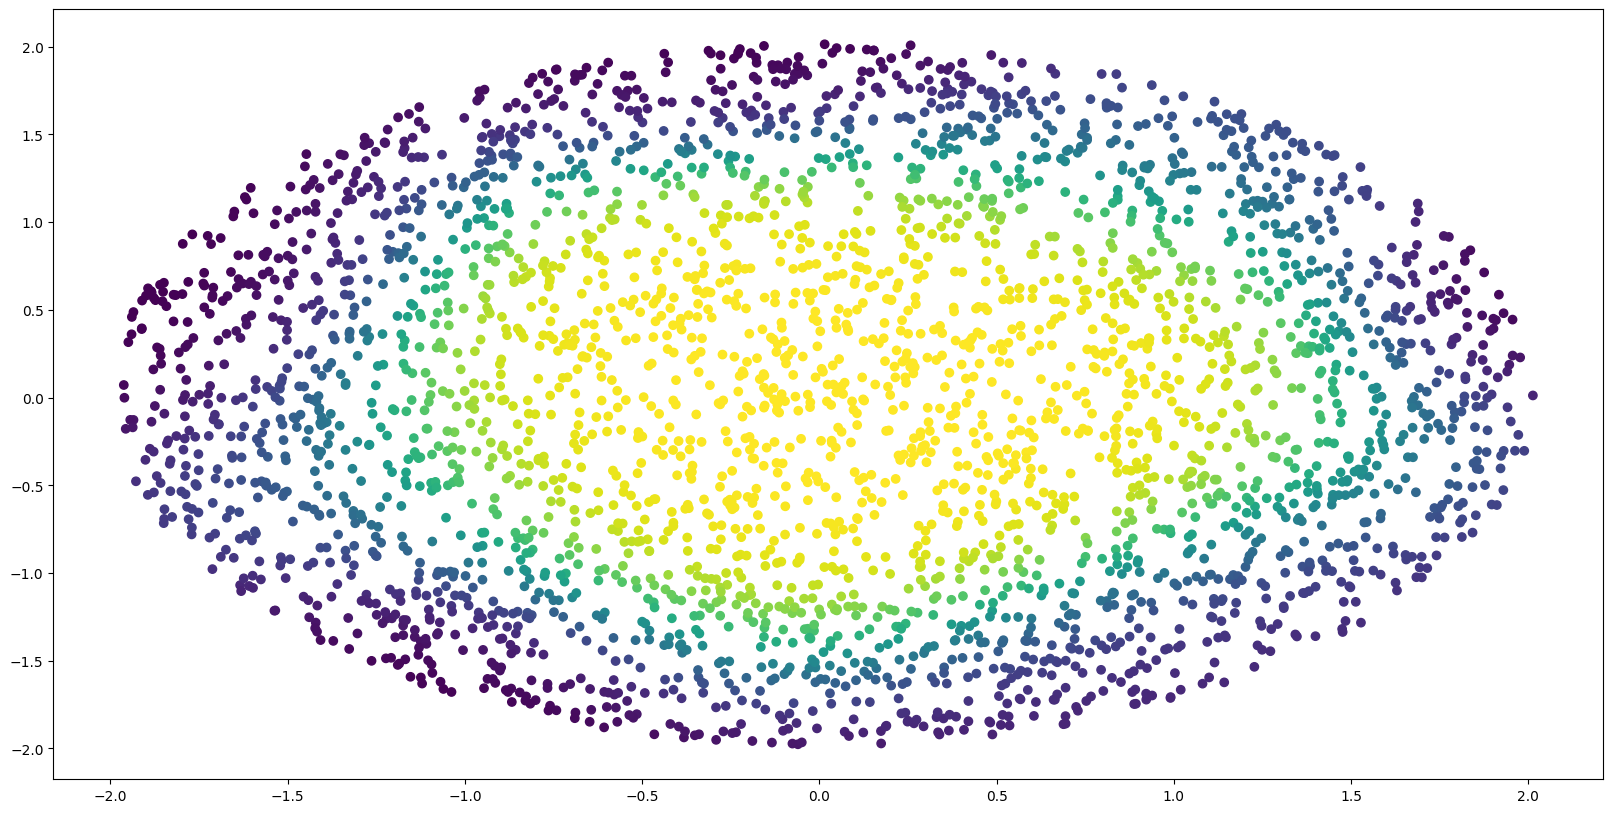

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=test_scores)
plt.show()

Это, конечно, очень красиво, но я не поняла, почему на картинке градиент, если последний слой сети сигмоида...
